## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

#### ~Karanj

---
## Step 0: Load The Data

In [3]:
#Cell 1
# import numpy:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy.random as rnd
from IPython.display import display
from textwrap import wrap
# Using CV2
import cv2
from sklearn.utils import shuffle
# Load pickled data
import pickle
import csv
import os



In [4]:
#Cell 2
# Load training and testing data
#`signnames.csv` contains mappings from the class id (integer) to the actual sign name.

training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open('signnames.csv', mode='r') as mapping_file:
    reader = csv.reader(mapping_file)
    signs = {rows[0]:rows[1] for rows in reader}   #row0 - id, row1 - name

###########################################################
#saved this file which includes 34799 original train images and another 34799 preprocessed images
with open('trainpp_brtNormAugm.p', mode='rb') as f:
    my_train = pickle.load(f)

myX_train, myy_train = my_train['features'], my_train['labels']

print("Image Shape -myX_train: {}".format(myX_train[0].shape))
print()
print("Training Set -myX_train:   {} samples".format(len(myX_train)))
############################################################
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print(y_train[1000:1020])
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))

Image Shape -myX_train: (32, 32, 3)

Training Set -myX_train:   69598 samples
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
#cell 3
### Used python, pandas or numpy methods rather than hard coding the results


# TODO: Number of training examples
n_train = format(len(X_train))

# TODO: Number of testing examples.
n_test = format(len(X_test))

# TODO: What's the shape of an traffic sign image?
image_shape = format(X_train[0].shape)

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))         
#len(set(y_train)) - http://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). 

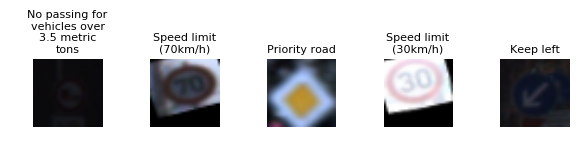

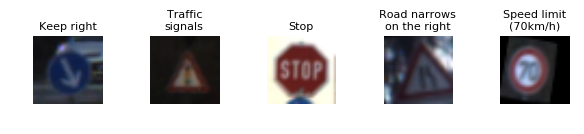

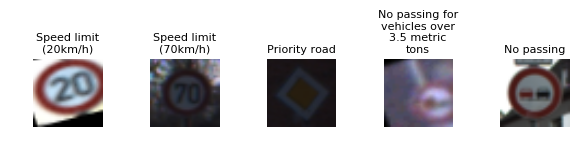

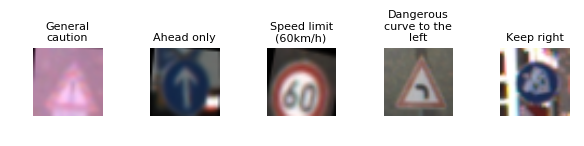

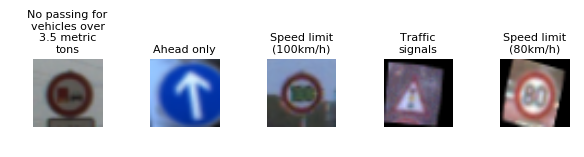

In [6]:
#Cell 4
### Data exploration visualization.

# Visualizations will be shown in the notebook.
%matplotlib inline


cnum_image = 5
rnum_image = 5

for r in range(rnum_image):
    fig = plt.figure()    # next row of images
    index = rnd.randint(0, len(myX_train), size = 5)
    for i in range(cnum_image):
        #The subplot() command specifies numrows, numcols, fignum where fignum ranges from 1 to numrows*numcols. 
        fig.add_subplot(1,cnum_image,i+1)
        #fig.subplots_adjust(wspace=1)
        plt.tight_layout()
        plt.imshow(myX_train[index] [i])   #[i] is index no (0 to 4) , i^th image from index
        #plt.title(y_train[index] [i])
        plt.title('\n'.join(wrap(signs[str(myy_train[index] [i])], 14)),fontsize=8)
        plt.axis('off')

        plt.show()

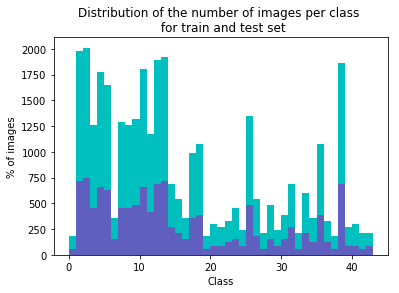

In [46]:
#Cell 4
unique, counts = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

#print(dict(zip(unique, counts)))
plt.hist(y_train, color = 'c', label = 'train', normed = False, bins=range(44))
plt.hist(y_test, color = 'm', alpha = 0.5, label = 'test', normed = False, bins=range(44))
plt.title('Distribution of the number of images per class \n for train and test set')
plt.xlabel('Class')
plt.ylabel('% of images')
plt.show()


----

## Step 2: Pre-Process, Design and Test a Model Architecture

Designing and implementation of a deep learning model that learns to recognize traffic signs. [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others). // not counted in this project
- Generate fake data. - Doubled size of Train dataset using preprocessing
- Neural network architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

In [12]:
#Cell 6
def brightness_process_image(Xpp_in, Xpp_out):
    
    #Brightness normalization
    cv2.normalize(Xpp_in, Xpp_out, 0, 255, cv2.NORM_MINMAX)
    
    # Brightness Augmentation
    Xpp_in = cv2.cvtColor(Xpp_in,cv2.COLOR_RGB2HSV)
    brightness = .25+np.random.uniform(0.4,0.9) #https://docs.python.org/2/library/random.html#random.random
    print(brightness)
    Xpp_in[:,:,2] = Xpp_in[:,:,2]*brightness
    Xpp_in = cv2.cvtColor(Xpp_in,cv2.COLOR_HSV2RGB)
    
    return Xpp_out

In [13]:
#Cell 7
def transform_image(image,ang_range,shear_range,trans_range):
# Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
# Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
# Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))
    
    image2 = np.zeros(X_train[0].shape, dtype='u1')
    # Preprocessing 
    image2 = brightness_process_image(image,image2)     # brightness Normalization & Augmentaion
    
    return image

In [14]:
#Cell 8
def preprocess_images(Xbtin_train, ybtin_train, Xbto_train, ybto_train):
    for i in range(0, len(Xbtin_train)):   #loop running for all train images
        for j in range(1):                #Loop produces 1 Augmented and normalized image for each base image
            image_transformed = transform_image(Xbtin_train[i],20,10,5).reshape((-1,32,32,3))    #Transformation function
            Xbto_train = np.concatenate((Xbto_train, image_transformed), axis=0)   #concatenate = Original + 2 Augmented images
            ybto_train = np.concatenate((ybto_train,ybtin_train[i].reshape((-1,)))) #label concatenation
    print(Xbtin_train.shape, Xbto_train.shape, ybto_train.shape, ybtin_train[5].shape) # final shape of dataset #can be commented
    return Xbto_train, ybto_train

#NOtes:
#reshaping and concatenation [see above, reshape((-1,32,32,3)) and reshape((-1,))]: 
#http://stackoverflow.com/documentation/numpy/1296/the-basics/6739/reshaping-and-concatenation-of-an-array#t=201702211832191612933

# Create Arrays to perform Augmentation on:
Xbtin_train = np.copy(X_train)
ybtin_train = np.copy(y_train)
Xbto_train = np.copy(Xbtin_train)
ybto_train = np.copy(ybtin_train)
print(Xbtin_train.shape, Xbto_train.shape, ybto_train.shape, ybtin_train[5].shape)

(34799, 32, 32, 3) (34799, 32, 32, 3) (34799,) ()


In [16]:
#Cell 9
start = timer()
Xbto_train, ybto_train = preprocess_images(Xbtin_train, ybtin_train, Xbto_train, ybto_train)
stop = timer()
print("Time elapsed in preprocessing: ",format((stop-start)/60))

#******************************************************************
# write this 'trainpp_brtNormAug.p' file which includes base images plus preprocessed images. TOtal 69598 images
your_data = {"features":Xbto_train, "labels":ybto_train}
with open('trainpp_brtNormAug.p', mode='wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

(34799, 32, 32, 3) (69598, 32, 32, 3) (69598,) ()
Time elapsed in preprocessing: %f 69.5923325152


(34799, 32, 32, 3) (69598, 32, 32, 3)
41 41
31 31
36 36


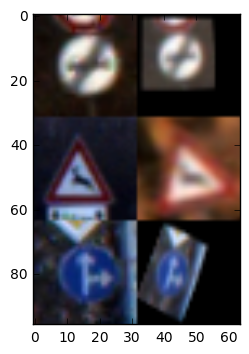

In [17]:
#Cell 10
#Randomly see any three  : Original image | PreProcessed image
print(Xbtin_train.shape, Xbto_train.shape)
res = np.hstack((Xbtin_train[255],Xbto_train[255],Xbtin_train[16000],Xbto_train[16000])) #stacking images side-by-side
res1 = np.hstack((Xb_train[1],Xbto_train[34799]))
res2 = np.hstack((Xb_train[250],Xbto_train[35099]))
res3 = np.hstack((Xb_train[1000],Xbto_train[35799]))

plt.imshow(res)
plt.imshow(np.vstack((res1,res2,res3)))
print(ybtin_train[1], ybto_train[34799])
print(ybtin_train[300], ybto_train[35099])
print(ybtin_train[1000], ybto_train[35799])

### Model Architecture

In [1]:
### Defined architecture here.


In [5]:
#Cell 11
#setup tensorflow
import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 128
keep_prob = tf.placeholder(tf.float32) # probability to keep units

In [6]:
#Cell 12
#Implement LeNet
# DropOut : https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/d5cf4454-1324-4524-9e2c-0ecca1f5c40e
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 0: Convolutional. Input = 32x32x3. Output = 32x32x3.
    wcA = tf.Variable(tf.truncated_normal((1, 1, 3, 3), mean = mu, stddev = sigma))
         # wc1 (height, width, input_depth, output_depth ,calculate filter h and w)
    wbA = tf.Variable(tf.zeros(3))
    stridesA = [1, 1, 1, 1] # (batch, height, width, depth)
    paddingA = 'VALID'
    convA = tf.nn.conv2d(x, wcA, stridesA, paddingA) + wbA   
    convA = tf.nn.conv2d(convA, wcA, stridesA, paddingA) + wbA   #Double 1x1  Convolution
    #----------------------------------------------
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x6.
        #(out_height = ceil(float(in_height - filter_height + 1) / float(strides[1])))
    wc1 = tf.Variable(tf.truncated_normal((3, 3, 3, 6), mean = mu, stddev = sigma))
         # wc1 (height, width, input_depth, output_depth ,calculate filter h and w)
    wb1 = tf.Variable(tf.zeros(6))
    strides1 = [1, 1, 1, 1] # (batch, height, width, depth)
    padding1 = 'VALID'
    conv1 = tf.nn.conv2d(convA, wc1, strides1, padding1) + wb1
    
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 30x30x6. Output = 15x15x6.
    #new_height = (input_height - filter_height)/S + 1;, (put filter_height=S and solve for S)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


    # TODO: Layer 2: Convolutional. Output = 13x13x32.
    wc2 = tf.Variable(tf.truncated_normal((3, 3, 6, 32), mean = mu, stddev = sigma))
         # wc1 (height, width, input_depth, output_depth ,calculate filter h and w)
    wb2 = tf.Variable(tf.zeros(32))
    strides2 = [1, 1, 1, 1] # (batch, height, width, depth)
    padding2 = 'VALID'
    conv2 = tf.nn.conv2d(conv1, wc2, strides2, padding2) + wb2
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 13x13x32. Output = 6x6x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #print(conv2.shape)
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    #*--------------------------------
    # TODO: Layer 3: Convolutional. Output = 4x4x64.
    wc3 = tf.Variable(tf.truncated_normal((3, 3, 32, 64), mean = mu, stddev = sigma))
         # wc1 (height, width, input_depth, output_depth ,calculate filter h and w)
    wb3 = tf.Variable(tf.zeros(64))
    strides3 = [1, 1, 1, 1] # (batch, height, width, depth)
    padding3 = 'VALID'
    conv3 = tf.nn.conv2d(conv2, wc3, strides3, padding3) + wb3
    
    # TODO: Activation.
    conv3 = tf.nn.relu(conv3)

    # TODO: Pooling. Input = 4x4x64. Output = 4x4x64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 1, 1, 1], strides=[1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.dropout(conv3, keep_prob)
    #*---------------------------------
    
    # TODO: Flatten. Input = 4x4x64. Output = 1024.
    fc0   = flatten(conv3)
    
    # TODO: Layer 4: Fully Connected. Input = 1024, Output = 256.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 256), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(256))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # TODO: Activation. & #DropOut
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 256. Output = 128.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(128))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation. & #DropOut
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 6: Fully Connected. Input = 128. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    
    regularizers = (tf.nn.l2_loss(wcA) 
                + tf.nn.l2_loss(wc1) 
                + tf.nn.l2_loss(wc2) 
                + tf.nn.l2_loss(wc3) 
                + tf.nn.l2_loss(fc1_W)
                + tf.nn.l2_loss(fc2_W)
                + tf.nn.l2_loss(fc3_W))
    
    return logits, regularizers

In [7]:
#Cell 13
#`x` is a placeholder for a batch of input images.
#`y` is a placeholder for a batch of output labels.
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

rate = tf.placeholder(tf.float32, (None))

one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [8]:
#Cell 14
### Train model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set is calculated and reported as well.

betas = [.05, .005, .0005, .00005]
validation_accuracy_list = []
#print(betas[1])

In [9]:
#Cell 15
#training pipeline

#rate = 0.0009

logits, regularizers = LeNet(x)
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) + betas[1]*regularizers 
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
#print(regularizers)

In [10]:
#Cell 16
#Model evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, rate: 0.0009})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
#Cell 17
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(myX_train)
    lr = 0.0015
    
    start = timer()
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        if i>0 and i%16==0:
            lr = 0.1*lr
            msg = "EPOCHS: " + format(i) + " and Validation accuracy is: " + format(validation_accuracy)+ " Learning Rate: " + format(lr)
            #print(msg)
        myX_train, myy_train = shuffle(myX_train, myy_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = myX_train[offset:end], myy_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8, rate: lr})
        #print(end)
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        validation_accuracy_list.append(validation_accuracy)
        print()
        
    stop = timer()
    print("Time elapsed for this run: {:.2f}".format((stop-start)/60))
    
    msg = "Model Trained and Validation accuracy is: " + format(validation_accuracy)
    print(msg)
    
    saver.save(sess, './lenet7')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.441

EPOCH 2 ...
Validation Accuracy = 0.617

EPOCH 3 ...
Validation Accuracy = 0.803

EPOCH 4 ...
Validation Accuracy = 0.864

EPOCH 5 ...
Validation Accuracy = 0.910

EPOCH 6 ...
Validation Accuracy = 0.908

EPOCH 7 ...
Validation Accuracy = 0.935

EPOCH 8 ...
Validation Accuracy = 0.941

EPOCH 9 ...
Validation Accuracy = 0.935

EPOCH 10 ...
Validation Accuracy = 0.924

EPOCH 11 ...
Validation Accuracy = 0.932

EPOCH 12 ...
Validation Accuracy = 0.939

EPOCH 13 ...
Validation Accuracy = 0.957

EPOCH 14 ...
Validation Accuracy = 0.952

EPOCH 15 ...
Validation Accuracy = 0.953

EPOCH 16 ...
Validation Accuracy = 0.948

EPOCH 17 ...
Validation Accuracy = 0.966

EPOCH 18 ...
Validation Accuracy = 0.971

EPOCH 19 ...
Validation Accuracy = 0.970

EPOCH 20 ...
Validation Accuracy = 0.968

EPOCH 21 ...
Validation Accuracy = 0.967

EPOCH 22 ...
Validation Accuracy = 0.971

EPOCH 23 ...
Validation Accuracy = 0.971

EPOCH 24 ...
Validation Accura

[0.44058956948537675, 0.61700680299140431, 0.80340136081453351, 0.86417233587122289, 0.90952380928052523, 0.90816326530612246, 0.93514739229024946, 0.9408163265846754, 0.93469387782133628, 0.92358276646694093, 0.93219954624197654, 0.9392290252136265, 0.95714285714285718, 0.95170068027210886, 0.95260770975056686, 0.94829931948460688, 0.96598639455782309, 0.97097505668934236, 0.96961451247165531, 0.96825396825396826, 0.96712018140589573, 0.97120181405895689, 0.97097505668934236, 0.97074829931972784, 0.9678004535147392, 0.96802721088435373, 0.97074829931972784, 0.96825396825396826, 0.96712018140589573, 0.96734693877551026]


(0, 31)

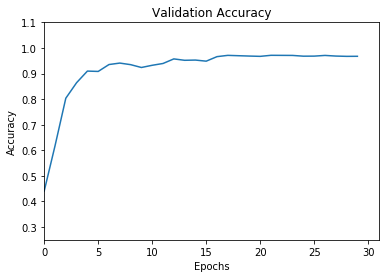

In [47]:
#Cell 18
print(validation_accuracy_list)
plt.plot(validation_accuracy_list)
plt.title("Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(.25,1.1)
plt.xlim(0,31)

In [16]:
#Cell 19
# EVALUATING given TEST dataset
save_file= './lenet7'
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, save_file)
    
    images_web_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(images_web_accuracy))

Test Accuracy = 0.957


---

## Step 3: Test a Model on New Images

To give myself more insight into how above model is working, downloaded 10 pictures of German traffic signs from the web and used model to predict the traffic sign type.

`signnames.csv` contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [17]:
### Load the images and Visualization.

In [18]:
#Cell 20
from matplotlib import gridspec

 and p
    image_new = cv2.imread(name)
    
    image_new = cv2.resize(image_new,(32,32))
    image_new = cv2.cvtColor(image_new,cv2.COLOR_BGR2RGB)
    #print(image_new.shape)
    return image_new

In [50]:
#Cell 21
from os.path import basename
newdata = [process_newimage_file("./German_signs/"+name) for name in os.listdir("./German_signs/")]
newdata = np.array(newdata ,dtype = 'u1')
print(newdata.shape)

namenewdata = [(os.path.splitext(name)[0]) for name in os.listdir("./German_signs/")]   #remove .jpg and take filename
print(namenewdata)
namenewdata = list(map(int, namenewdata)) #list of strings to List of ints # see print outputs
print(namenewdata)

#http://stackoverflow.com/questions/30167538/convert-a-numpy-ndarray-to-stringor-bytes-and-convert-it-back-to-numpy-ndarray
arr =np.array(namenewdata)
ts = arr.tostring()
y_namenewdata = (np.fromstring(ts,dtype=int))
print(y_namenewdata)


(10, 32, 32, 3)
['12', '1', '26', '25', '7', '31', '38', '9', '14', '2']
[12, 1, 26, 25, 7, 31, 38, 9, 14, 2]
[12  1 26 25  7 31 38  9 14  2]


[0, 1, 2, 3, 4]


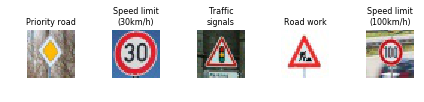

[5, 6, 7, 8, 9]


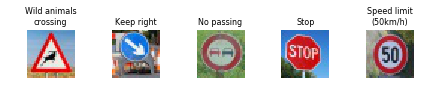

In [20]:
#Cell 22
cnum_image = 5
rnum_image = 2


for r in range(rnum_image):
    fig = plt.figure()    # next row of images
    index = list(x+(r*5) for x in range(0, 5))
    print(index)
    for i in range(cnum_image):
        #The subplot() command specifies numrows, numcols, fignum where fignum ranges from 1 to numrows*numcols. 
        fig.add_subplot(1,cnum_image,i+1)
        plt.tight_layout()
        plt.imshow(newdata[index] [i])   #[i] is index no (0 to 4) , i^th image from index
        plt.title('\n'.join(wrap(signs[str(y_namenewdata[index] [i])], 14)),fontsize=8)
        plt.axis('off')
    plt.show()

### Predict the Sign Type for Each Image

In [21]:
### Run the predictions here and use the model to output the prediction for each image.
### pre-process the images with the same pre-processing pipeline used earlier.

# Visualizations will be shown in the notebook.
%matplotlib inline

In [22]:
#Cell 23
Visualiz
    for i in range(0, len(X_in)):  
        cv2.normalize(X_in[i],Xb_out[i],0, 255, cv2.NORM_MINMAX)
        
        Xb_out[i] = cv2.cvtColor(Xb_out[i],cv2.COLOR_RGB2HSV)
        brightness = .25+np.random.uniform(0.4,0.9) #https://docs.python.org/2/library/random.html#random.random
        #print(brightness)
        Xb_out[i,:,:,2] = Xb_out[i,:,:,2]*brightness
        Xb_out[i] = cv2.cvtColor(Xb_out[i],cv2.COLOR_HSV2RGB)
    
    return Xb_out

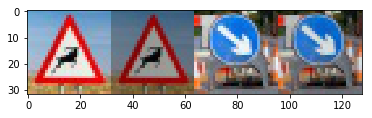

In [30]:
#Cell 24
# Visualization after Preprocessing downloaded imagaes
Xp_newdata = np.zeros(newdata.shape,dtype='u1')
Xp_newdata = pre_process_image(newdata, Xp_newdata)
res = np.hstack((newdata[5],Xp_newdata[5],newdata[6],Xp_newdata[6])) #stacking images side-by-side
plt.imshow(res)

### Analyze Performance

In [31]:
### Calculate the accuracy for these 10 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [51]:
#Cell 25
save_file= './lenet7'
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, save_file)
    
    images_web_accuracy = evaluate(Xp_newdata, y_namenewdata)
    print("Web-downloaded dataset Accuracy = {:.3f}".format(images_web_accuracy))
    

Web-downloaded dataset Accuracy = 0.700


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions. [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) was helpful here

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, we can confirm these are the 3 largest probabilities in `a`. Also notice `[3, 0, 5]` are the corresponding indices.

In [33]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web.

In [34]:
#Cell 26
save_file= './lenet7'
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, save_file)
    
    feed_dict_new = {x: Xp_newdata, y: y_namenewdata, keep_prob: 1.0}
    logi = session.run(logits, feed_dict_new)
    predicts = session.run(tf.nn.top_k(logi, k=5, sorted=True))
    proba = session.run(tf.nn.softmax(predicts[0]))


Selecting only the top 5 predictions and rerunning softmax


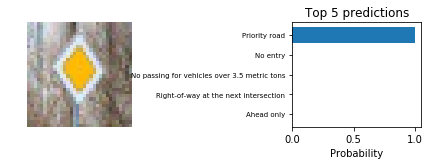

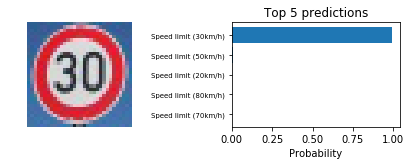

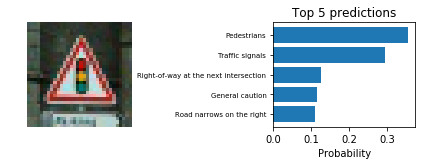

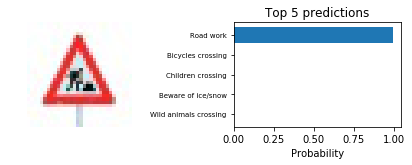

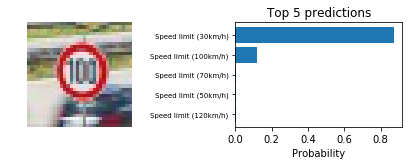

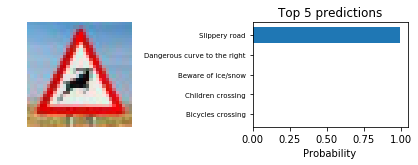

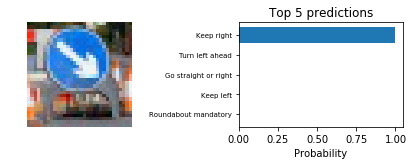

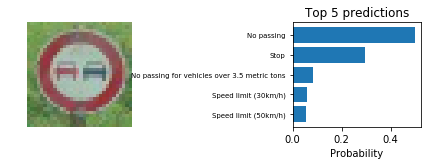

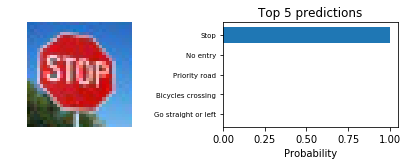

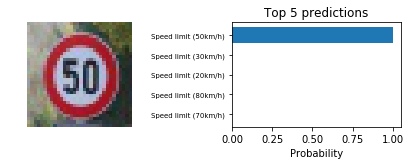

In [35]:
#Cell 27
print('Selecting only the top 5 predictions and rerunning softmax')
num_own_examples = len(Xp_newdata)
for i in range(num_own_examples):
    
    probas = proba[i]
    names = np.asarray([signs[str(p)] for p in predicts[1][i]])
    
    plt.figure(1)

    plt.subplot(221)
    plt.imshow(newdata[i])
    plt.axis('off')
    
    plt.subplot(222)
    y_pos = np.arange(len(names))[::-1]
    plt.barh(y_pos,probas, align='center')
    plt.yticks(y_pos, names, fontsize=7)
    plt.xlabel('Probability')
    plt.title('Top 5 predictions')
    
    
    plt.tight_layout()
    plt.show()


### Project Writeup

Project is documented in pdf file